In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.utils.data_loader import load_all_locations

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from pandas.plotting import lag_plot, autocorrelation_plot

#XGBoost
import xgboost as xgb


In [3]:
data = load_all_locations()

In [4]:
data[0].columns

Index(['time', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_sp

In [5]:
np.corrcoef(
    data[0][(data[0].set_type == "TRAIN")][
        "direct_rad:W"
    ],
    data[1][(data[1].set_type == "TRAIN")]["y"],
)[0, 1], np.corrcoef(
    data[0][(data[0].set_type == "TRAIN")][
        "direct_rad_1h:J"
    ],
    data[1][(data[1].set_type == "TRAIN")]["y"],
)[
    0, 1
]

(0.6359680563162974, 0.6262562245410207)

In [6]:
np.corrcoef(
    data[0][(data[0].set_type == "TEST")][
        "direct_rad:W"
    ],
    data[1][(data[1].set_type == "TEST")]["y"],
)[0, 1], np.corrcoef(
    data[0][(data[0].set_type == "TEST")][
        "direct_rad_1h:J"
    ],
    data[1][(data[1].set_type == "TEST")]["y"],
)[
    0, 1
]

(0.6103005666469682, 0.59679894891713)

<Axes: xlabel='y(t)', ylabel='y(t + 2)'>

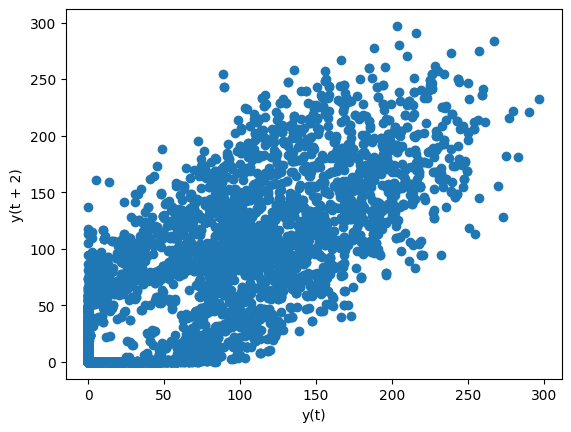

In [7]:

lag_plot(data[0][(data[0].time.dt.month == 4) & (data[0].set_type == "TRAIN")]['diffuse_rad:W'], lag=2)

In [8]:
# Feature engineering for predicting solar power production using weather data
# Using the following features:
# 'time', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
# 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
# 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
# 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
# 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
# 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
# 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
# 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
# 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
# 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
# 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
# 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
# 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
# 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
# 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
# 'set_type', 'location'

# 1. Add time features
# 2. Add weather features
# 3. Add solar position features
# 4. Add solar power features


def feature_engineering(X: pd.DataFrame):
    # 1. Add time features
    X["time"] = pd.to_datetime(X["time"])
    X["year"] = X["time"].dt.year
    X["month"] = X["time"].dt.month
    X["day"] = X["time"].dt.day
    X["hour"] = X["time"].dt.hour
    X["day_of_week"] = X["time"].dt.dayofweek
    X["day_of_year"] = X["time"].dt.dayofyear
    # X["quarter"] = X["time"].dt.quarter
    # X["is_weekend"] = X["day_of_week"].isin([5, 6]).astype(int)
    # X["is_weekday"] = X["day_of_week"].isin([0, 1, 2, 3, 4]).astype(int)

    # Add lag and ahead features for temperature
    # X["temp_1h"] = X["t_1000hPa:K"].shift(1)
    # X["temp_2h"] = X["t_1000hPa:K"].shift(2)
    # X["temp_1h-"] = X["t_1000hPa:K"].shift(-1)
    # X["temp_2h-"] = X["t_1000hPa:K"].shift(-2)

    # Add lag and ahead features for solar irradiance
    # X["direct_rad_1h"] = X["direct_rad:W"].shift(1)
    # X["direct_rad_2h"] = X["direct_rad:W"].shift(2)
    # X["direct_rad_1h-"] = X["direct_rad:W"].shift(-1)
    # X["direct_rad_2h-"] = X["direct_rad:W"].shift(-2)

    # Add lag and ahead features for diffuse radiance
    # X["diffuse_rad_1h"] = X["diffuse_rad:W"].shift(1)
    # X["diffuse_rad_2h"] = X["diffuse_rad:W"].shift(2)
    # X["diffuse_rad_1h-"] = X["diffuse_rad:W"].shift(-1)
    # X["diffuse_rad_2h-"] = X["diffuse_rad:W"].shift(-2)

    # Add lag and ahead features for relative humidity
    # X["rel_hum_1h"] = X["relative_humidity_1000hPa:p"].shift(1)
    # X["rel_hum_2h"] = X["relative_humidity_1000hPa:p"].shift(2)
    X["rel_hum_1h-"] = X["relative_humidity_1000hPa:p"].shift(-1)
    X["rel_hum_2h-"] = X["relative_humidity_1000hPa:p"].shift(-2)

    # Add lag and ahead features for effective cloud cover
    # X["eff_cloud_1h"] = X["effective_cloud_cover:p"].shift(1)
    # X["eff_cloud_2h"] = X["effective_cloud_cover:p"].shift(2)
    X["eff_cloud_1h-"] = X["effective_cloud_cover:p"].shift(-1)
    X["eff_cloud_2h-"] = X["effective_cloud_cover:p"].shift(-2)

    # Add lag and ahead features for precipitation
    # X["precip_5min_1h"] = X["precip_5min:mm"].shift(1)
    # X["precip_5min_2h"] = X["precip_5min:mm"].shift(2)
    X["precip_5min_1h-"] = X["precip_5min:mm"].shift(-1)
    X["precip_5min_2h-"] = X["precip_5min:mm"].shift(-2)

    # Relationship between effective cloud cover and precipitation
    X["eff_cloud_precip_1h"] = X["eff_cloud_1h-"] * X["precip_5min_1h-"]

    # Relationship between effective cloud cover and sun irradiance
    X["eff_cloud_irrad_1h"] = X["eff_cloud_1h-"] * X["direct_rad:W"]

    # Relationship between effective cloud cover and temperature
    X["eff_cloud_temp_1h"] = X["eff_cloud_1h-"] * X["t_1000hPa:K"]

    # Replace "location" with One hot encoding
    X = pd.get_dummies(X, columns=["location"], dtype=int)

    X.fillna(method="ffill", inplace=True)
    X.fillna(method="bfill", inplace=True)

    # Drop columns containing only NaN values
    X = X.dropna(axis=1, how="all")

    X = X.drop(
        columns=[
            "ceiling_height_agl:m",
            "cloud_base_agl:m",
            "snow_density:kgm3",
            "clear_sky_energy_1h:J",
            "relative_humidity_1000hPa:p",
            "diffuse_rad_1h:J",
            "direct_rad_1h:J",
            "snow_depth:cm",
            "fresh_snow_12h:cm",
            "fresh_snow_6h:cm",
            "fresh_snow_24h:cm",
            "snow_water:kgm2",
            "effective_cloud_cover:p",
        ],
        errors="ignore",
    )

    return X

In [9]:
from src.utils.data_loader import load_val_dates, load_all_vals


dates = load_val_dates()
# Shift dates 1 year back
dates = [pd.to_datetime(date) - pd.DateOffset(years=1) for date in dates]


vals = load_all_vals()
vals = feature_engineering(vals)
vals.reset_index().drop(columns="index", inplace=True)

C:\Users\siver\AppData\Local\Temp\ipykernel_30788\3820082699.py:87: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
C:\Users\siver\AppData\Local\Temp\ipykernel_30788\3820082699.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="bfill", inplace=True)


In [10]:
X = feature_engineering(data[0].copy())

X = X[(X.location_A == 1)]

# Find rows containing NaN values
X = X

# Extract random week samples from the summer months as test set
test_set = X[X.set_type == "TEST"]
# X = X[~X.index.isin(test_set.index)]

# Extract random week samples from the winter months as validation set
val_set = X[(X.time.isin(dates))]
# X = X[~X.index.isin(val_set.index)]

# Drop set_type
X = X[X.set_type == "TRAIN"].drop(columns=["set_type"])
X.sort_values(by=["time"], inplace=True)

test_set = test_set.drop(columns=["set_type"])
val_set = val_set.drop(columns=["set_type"])
test_set.sort_values(by=["time"], inplace=True)
val_set.sort_values(by=["time"], inplace=True)

X_train = X.copy()[~X.time.isin(dates)].drop(columns=["time"])
X_test = test_set.drop(columns=["time"])
X_val = val_set[val_set.time.isin(dates)].drop(columns=["time"])


# Scale features using MinMax
X_scaler = MinMaxScaler()
X_train[X_train.columns] = X_scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = X_scaler.transform(X_test[X_test.columns])
X_val[X_val.columns] = X_scaler.transform(X_val[X_val.columns])


C:\Users\siver\AppData\Local\Temp\ipykernel_30788\3820082699.py:87: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
C:\Users\siver\AppData\Local\Temp\ipykernel_30788\3820082699.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="bfill", inplace=True)


In [11]:
# Create y_train from data[1] with same indices as X
from sklearn.preprocessing import MinMaxScaler


scalerA = MinMaxScaler()
scalerB = MinMaxScaler()
scalerC = MinMaxScaler()

y = data[1].copy()

y = y[y.location == "A"]
y_test_df = y[y.time.isin(test_set.time)]
y_test_df = y_test_df.sort_values(by=["time"])
y_val_df = y[y.time.isin(dates)]
y_val_df = y_val_df.sort_values(by=["time"])
y_train_df = y[y.time.isin(X.time)]
y_train_df = y_train_df.sort_values(by=["time"])

y_test = y_test_df["y"]
y_val = y_val_df["y"]
y_train = y_train_df[y_train_df.set_type == "TRAIN"][~y_train_df.time.isin(dates)]["y"]

# Scale features using MinMax
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))


In [12]:
y_train.shape, y_test.shape, y_val.shape, X_train.shape, X_test.shape, X_val.shape

((28905, 1), (4394, 1), (720, 1), (28905, 50), (4394, 50), (720, 50))

c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorica

[0]	test-mae:0.11726	train-mae:0.13635	eval-mae:0.16377
[1]	test-mae:0.10700	train-mae:0.12443	eval-mae:0.15002
[2]	test-mae:0.09812	train-mae:0.11394	eval-mae:0.13783
[3]	test-mae:0.09022	train-mae:0.10467	eval-mae:0.12697
[4]	test-mae:0.08314	train-mae:0.09645	eval-mae:0.11793
[5]	test-mae:0.07689	train-mae:0.08920	eval-mae:0.11041
[6]	test-mae:0.07115	train-mae:0.08274	eval-mae:0.10384
[7]	test-mae:0.06610	train-mae:0.07708	eval-mae:0.09857
[8]	test-mae:0.06151	train-mae:0.07204	eval-mae:0.09383
[9]	test-mae:0.05748	train-mae:0.06760	eval-mae:0.08952
[10]	test-mae:0.05383	train-mae:0.06367	eval-mae:0.08581
[11]	test-mae:0.05050	train-mae:0.06015	eval-mae:0.08274
[12]	test-mae:0.04756	train-mae:0.05701	eval-mae:0.08009
[13]	test-mae:0.04503	train-mae:0.05426	eval-mae:0.07802
[14]	test-mae:0.04267	train-mae:0.05185	eval-mae:0.07622
[15]	test-mae:0.04051	train-mae:0.04961	eval-mae:0.07403
[16]	test-mae:0.03856	train-mae:0.04768	eval-mae:0.07265
[17]	test-mae:0.03679	train-mae:0.04596	e

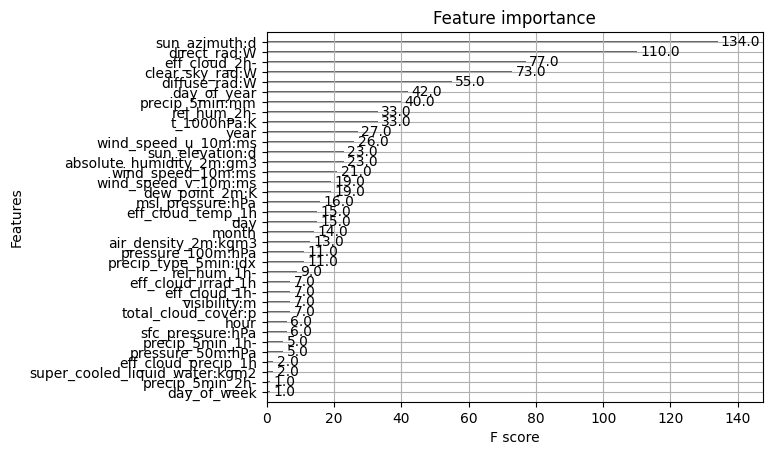

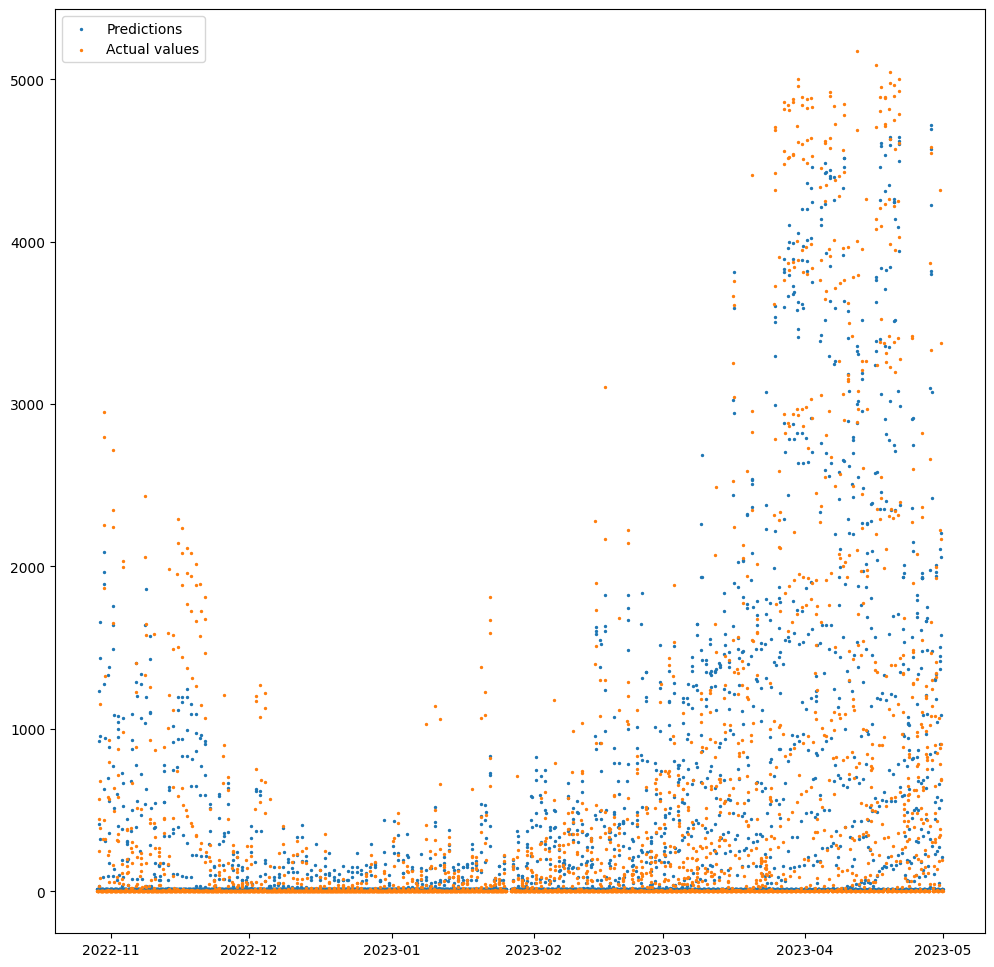

MAE:  135.1978134290533


In [13]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

# Set parameters
param = {
    # "max_depth": 5,
    # "eta": 0.4,
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "max_depth": 7,
    "n_estimators": 83,
    "min_child_weight": 3,
    "colsample_bytree": 0.8,
    "subsample": 0.9,
    "reg_alpha": 0,
    "gamma": 0.3,
    "reg_lambda": 1,
    "eta": 0.1,
}
evallist = [(dtest, "test"), (dtrain, "train"), (dval, "eval")]
num_round = 100

# Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=20)

# Predict
preds = bst.predict(dtest)

# Plot feature importance
xgb.plot_importance(bst)
plt.rcParams["figure.figsize"] = [12, 12]
plt.show()

# Get list of most important features
feature_importance = bst.get_score(importance_type="gain")
feature_importance = sorted(
    feature_importance.items(), key=lambda x: x[1], reverse=True
)[:-17]
feature_importance = [x[0] for x in feature_importance]

# Plot predictions vs actual values
plt.scatter(y_test_df.time, y_scaler.inverse_transform(preds.reshape(-1, 1)), s=2)
plt.scatter(y_test_df.time, y_scaler.inverse_transform(y_test), s=2)
plt.legend(["Predictions", "Actual values"])
plt.show()

# MAE
mae = mean_absolute_error(
    y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(preds.reshape(-1, 1))
)
print("MAE: ", mae)

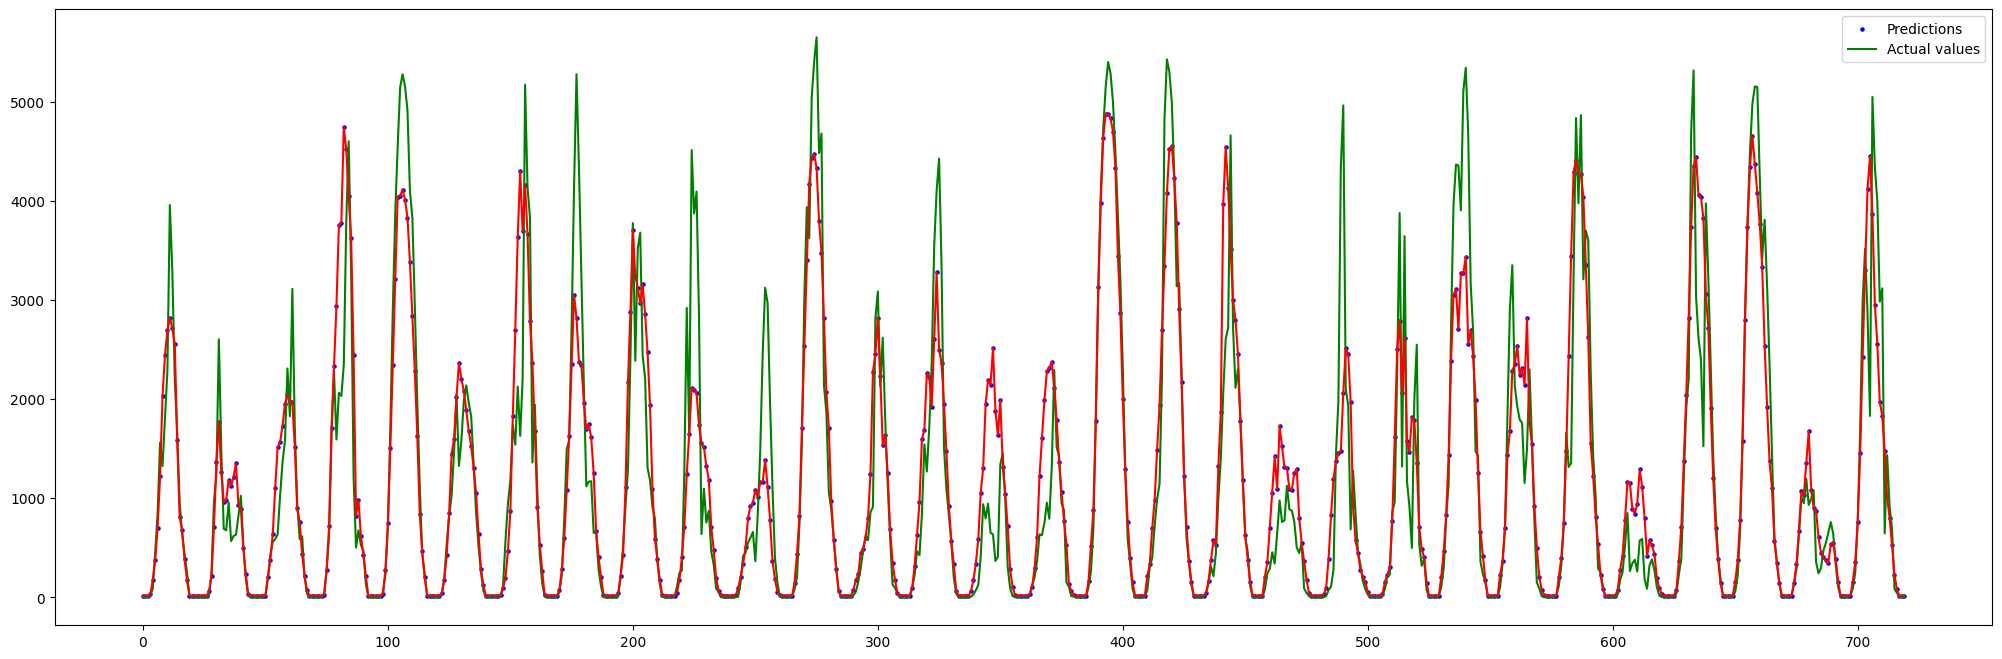

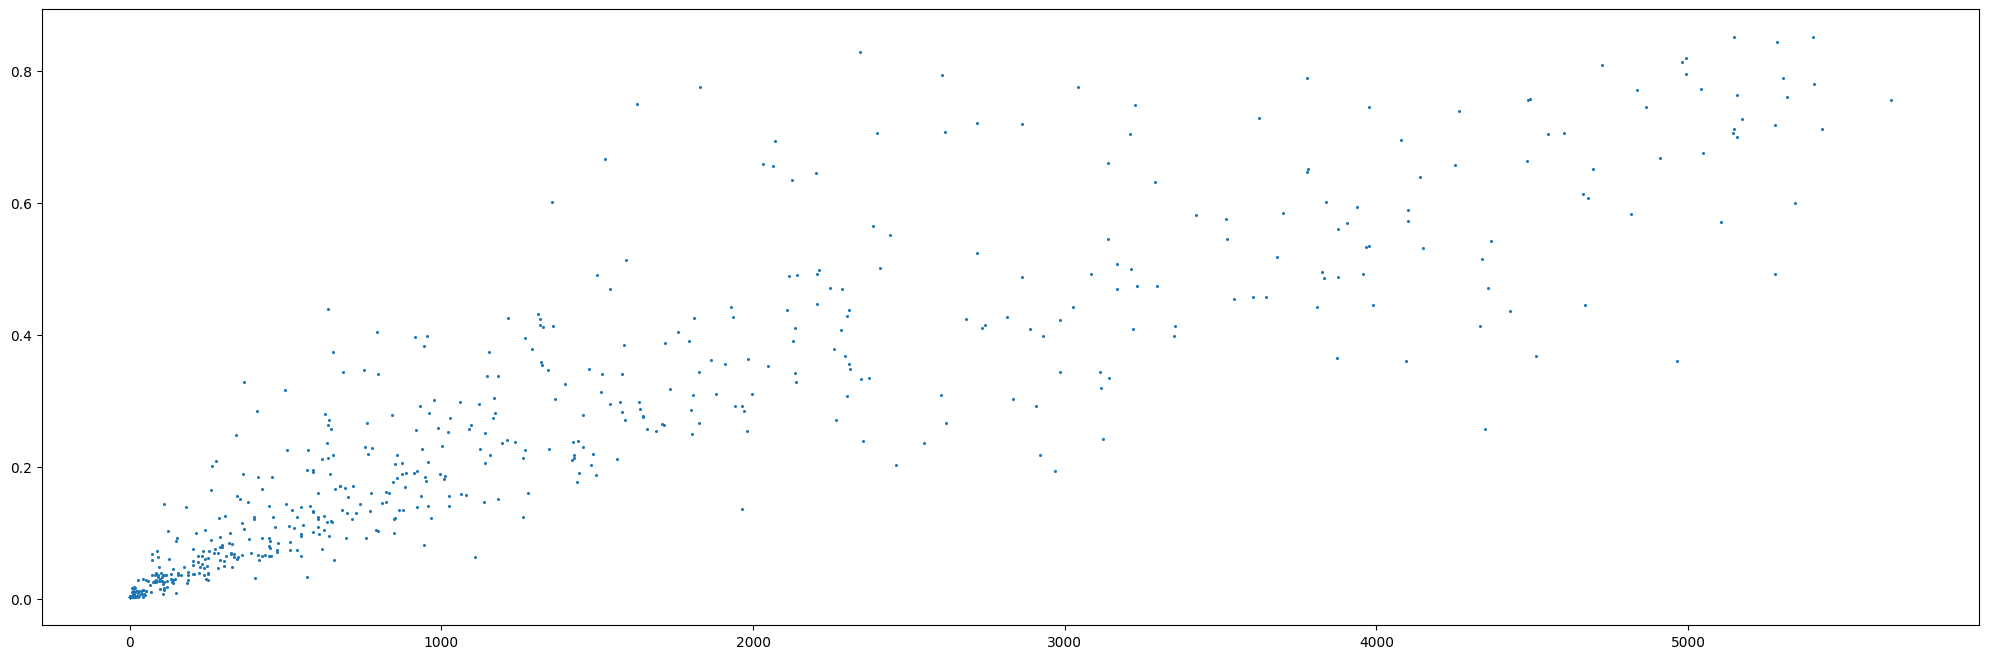

357.8470316339069


In [14]:
# Validate
preds_val = bst.predict(dval)
plt.rcParams["figure.figsize"] = [25, 8]
plt.scatter(y_val_df.reset_index().index.tolist(), y_scaler.inverse_transform(preds_val.reshape(-1, 1)).T.tolist()[0], c="blue", s=5)
plt.plot(y_val_df["y"].tolist(), c="green")
plt.plot(y_scaler.inverse_transform(preds_val.reshape(-1, 1)).T.tolist()[0], c="red")
plt.legend(["Predictions", "Actual values"])
plt.show()

# Validate
plt.scatter(y_val_df["y"], preds_val, s=1.5)
plt.show()

# MAE
mae = mean_absolute_error(
    y_val_df["y"].tolist(),
    y_scaler.inverse_transform(preds_val.reshape(-1, 1)).T.tolist()[0],
)
print(mae)

In [15]:
feature_importance

['direct_rad:W',
 'diffuse_rad:W',
 'sun_elevation:d',
 'clear_sky_rad:W',
 'eff_cloud_2h-',
 'eff_cloud_irrad_1h',
 'rel_hum_2h-',
 'eff_cloud_temp_1h',
 'sun_azimuth:d',
 'precip_5min_2h-',
 'visibility:m',
 'hour',
 'eff_cloud_1h-',
 'day_of_year',
 'month',
 'precip_5min:mm',
 'rel_hum_1h-',
 'pressure_100m:hPa',
 'wind_speed_v_10m:ms']

In [16]:
list(set(X.columns) - set(feature_importance))

['time',
 'wind_speed_w_1000hPa:ms',
 'elevation:m',
 'total_cloud_cover:p',
 'precip_type_5min:idx',
 'wind_speed_u_10m:ms',
 'dew_or_rime:idx',
 'is_day:idx',
 'snow_melt_10min:mm',
 'msl_pressure:hPa',
 'dew_point_2m:K',
 'fresh_snow_1h:cm',
 'is_in_shadow:idx',
 'year',
 'location_B',
 'rain_water:kgm2',
 't_1000hPa:K',
 'location_A',
 'eff_cloud_precip_1h',
 'air_density_2m:kgm3',
 'snow_drift:idx',
 'fresh_snow_3h:cm',
 'wind_speed_10m:ms',
 'prob_rime:p',
 'absolute_humidity_2m:gm3',
 'super_cooled_liquid_water:kgm2',
 'day_of_week',
 'pressure_50m:hPa',
 'sfc_pressure:hPa',
 'location_C',
 'precip_5min_1h-',
 'day']

In [17]:
# Run XGBoost on X and y
X_train = X.copy().drop(columns=["time"])[feature_importance]
X_test = test_set.drop(columns=["time"])[feature_importance]
X_val = val_set.drop(columns=["time"])[feature_importance]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

# Set parameters
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:squarederror', 'eval_metric': 'mae'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 100

# Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# Predict
preds = bst.predict(dtest)

# Plot feature importance
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [12, 12]
plt.show()

# Get list of most important features
feature_importance = bst.get_score(importance_type="gain")
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
feature_importance = [x[0] for x in feature_importance]

# Plot predictions vs actual values
plt.scatter(y_test_df.time, preds)
plt.scatter(y_test_df.time, y_test_df["y"])
plt.legend(["Predictions", "Actual values"])
plt.show()

# MAE
mae = np.mean(np.abs(preds - y_test))
print("MAE: ", mae)

c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\siver\azure\venv913\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorica

XGBoostError: [11:55:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\data\data.cc:501: Check failed: this->labels.Size() % this->num_row_ == 0 (28905 vs. 0) : Incorrect size for labels.